In [73]:
import numpy as np
import pickle
import healpy as hp
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import scipy
from scipy.optimize import minimize
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from getdist import plots, MCSamples
import getdist
sys.path.append('../shared')
sys.path.append('../nilc_pipeline')
sys.path.append('../multifrequency_pipeline')
from input import Info
from generate_maps import generate_freq_maps
from load_weight_maps import load_wt_maps
from utils import setup_output_dir, tsz_spectral_response, GaussianNeedlets, build_NILC_maps

In [74]:
font = {'size'   : 20, 'family':'STIXGeneral'}
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

getdist.plots.GetDistPlotSettings.legend_fontsize = 14

### To run this notebook, first run nilc_pipeline/main.py and template_fitting_pipeline/main.py with save_files=1 in the yaml files. The variable save_dir below should be the directory in which to save the plots (set save_dir=None if you don't want to save the plots).

In [75]:
save_dir = 'pipeline_plots'

sim = 0
if not os.path.isdir(save_dir):
    env = os.environ.copy()
    subprocess.call(f'mkdir {save_dir}', shell=True, env=env)


## Read input yaml file

In [76]:
# main input file containing most specifications 
input_file = '/Users/kristen/Documents/GitHub/NILC-Inference-Pipeline/nilc_pipeline/laptop.yaml'

# read in the input file and set up relevant info object
inp = Info(input_file)
inp.ell_sum_max = inp.ellmax

ells = np.arange(inp.ellmax+1)
res = stats.binned_statistic(ells[2:], ells[2:], statistic='mean', bins=inp.Nbins)
mean_ells = np.round((res[1][:-1]+res[1][1:])/2)

# Sample input maps and power spectra

saved pipeline_plots/input_maps.pdf


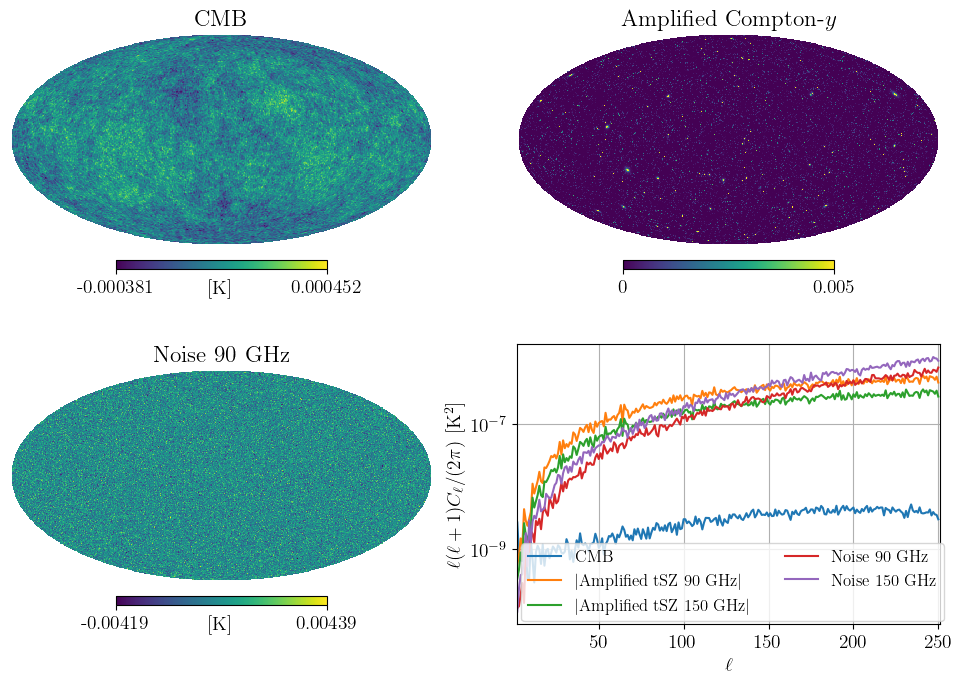

In [162]:
cmb_cl, tsz_cl, noise1_cl, noise2_cl, cmb_map, tsz_map, noise1_map, noise2_map = generate_freq_maps(sim, inp, save=False)
ells_sum = np.arange(inp.ell_sum_max+1)

g_cmb = np.array([1., 1.])
g_tsz = tsz_spectral_response(inp.freqs)

fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()
margins=None #(1,1,1,1)

plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':14})

for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        hp.mollview(cmb_map, fig=1, hold=True, title='CMB', format='%.03g')
    elif n==1:
        hp.mollview(tsz_map, fig=2, hold=True, title=r'Amplified Compton-$y$', format='%.03g', min=0, max=0.005)
    elif n==2:
        hp.mollview(noise1_map, fig=3, hold=True, title='Noise 90 GHz', format='%.03g')
    else:
        to_dl = ells_sum*(ells_sum+1)/2/np.pi
        plt.plot(ells_sum[2:], (to_dl*cmb_cl)[2:], label='CMB')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[0]*tsz_cl)[2:], label=r'$|$Amplified tSZ 90 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[1]*tsz_cl)[2:], label=r'$|$Amplified tSZ 150 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*noise1_cl)[2:], label='Noise 90 GHz', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*noise2_cl)[2:], label='Noise 150 GHz', linestyle='solid')
        plt.xlabel(r'$\ell$', fontsize=14)
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}/(2\pi)$ [$\mathrm{K}^2$]', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid()
        plt.legend(fontsize=12, ncol=2, loc=(0.01,0.01))
        plt.yscale('log')
        plt.xlim(2,inp.ell_sum_max+1)
    if n==0 or n==2:
        plt.text(0.47, -0.02, r'$[\mathrm{K}]$', transform=ax.transAxes,size=14)

if save_dir:
    plt.savefig(f'{save_dir}/input_maps.pdf', bbox_inches="tight")
    print(f'saved {save_dir}/input_maps.pdf')


plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})

# Needlet filters

saved pipeline_plots/needlet_filters.pdf


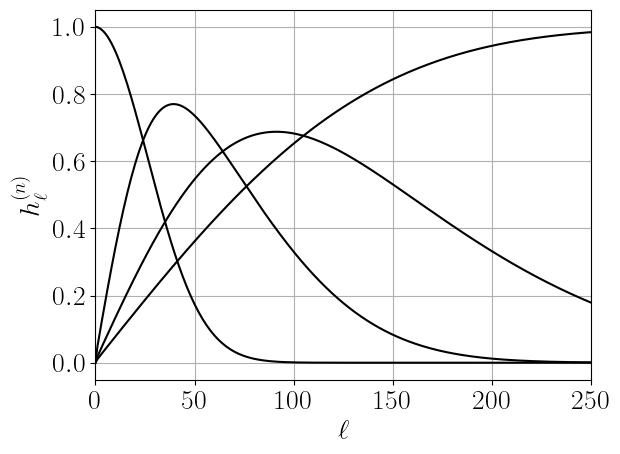

In [78]:
ells_sum, h = GaussianNeedlets(inp)
for n in range(inp.Nscales):
    plt.plot(ells_sum, h[n], color='k')
plt.grid()
plt.xlim(0,inp.ell_sum_max)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$h_\ell^{(n)}$')
if save_dir:
    plt.savefig(f'{save_dir}/needlet_filters.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/needlet_filters.pdf')

# NILC Weight maps

In [79]:
CMB_wt_maps, tSZ_wt_maps = load_wt_maps(inp, sim, scaling=[0,0,0,0,0])

## Preserved CMB Component

saved pipeline_plots/weight_maps_CMB.pdf


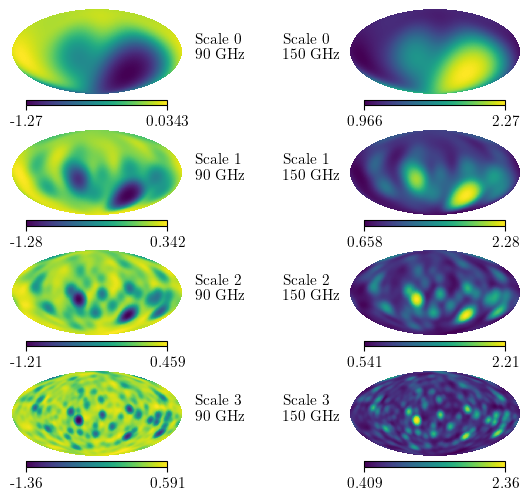

In [80]:
plt.rcParams.update({'font.size':11})

fig, axs = plt.subplots(inp.Nscales, len(inp.freqs), figsize=(8,6))
axs = axs.flatten()

ax = 0
for n in range(inp.Nscales):
    for i in range(len(inp.freqs)):
        plt.axes(axs[ax])
        hp.mollview(CMB_wt_maps[n][i], hold=True, title='', format='%.03g')
        if i == 0:
            plt.text(0.85, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        elif i == 1:
            plt.text(-0.04, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/weight_maps_CMB.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/weight_maps_CMB.pdf')
    
plt.rcParams.update({'font.size':20})

## Preserved tSZ Component

saved pipeline_plots/weight_maps_ftSZ.pdf


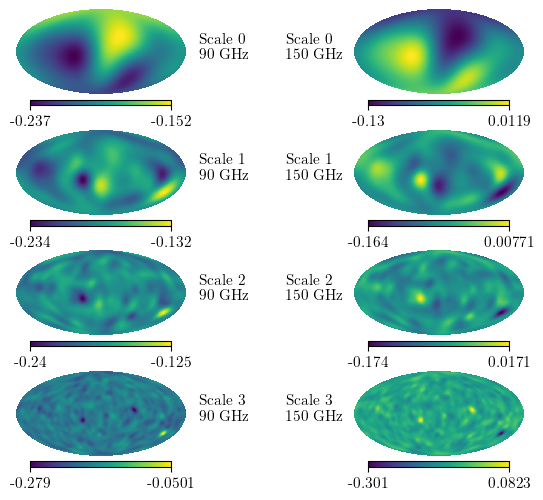

In [81]:
plt.rcParams.update({'font.size':11})

fig, axs = plt.subplots(inp.Nscales, len(inp.freqs), figsize=(8,6))
axs = axs.flatten()

ax = 0
for n in range(inp.Nscales):
    for i in range(len(inp.freqs)):
        plt.axes(axs[ax])
        hp.mollview(tSZ_wt_maps[n][i], hold=True, title='', format='%.03g')
        if i == 0:
            plt.text(0.85, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        elif i == 1:
            plt.text(-0.04, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/weight_maps_ftSZ.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/weight_maps_ftSZ.pdf')
    
plt.rcParams.update({'font.size':20})

# Acmb and Aftsz plots for template-fitting and NILC

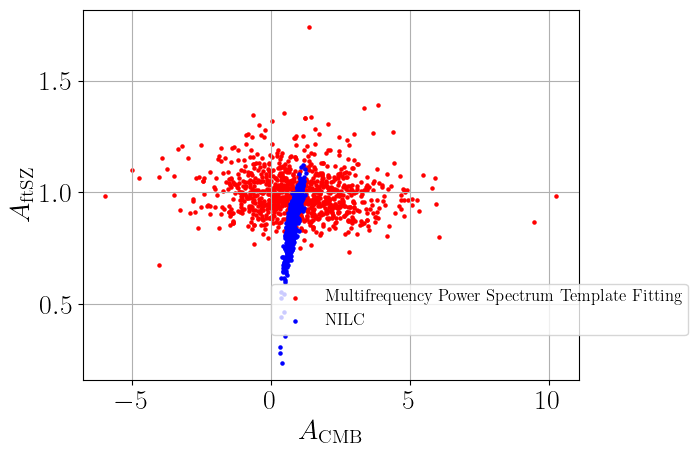

In [82]:
acmb_array_nilc = pickle.load(open(f'{inp.output_dir}/acmb_array_nilc.p', 'rb'))
atsz_array_nilc = pickle.load(open(f'{inp.output_dir}/atsz_array_nilc.p', 'rb'))
acmb_array_template_fitting = pickle.load(open(f'{inp.output_dir}/acmb_template_fitting_numerical.p', 'rb'))
atsz_array_template_fitting = pickle.load(open(f'{inp.output_dir}/atsz_template_fitting_numerical.p', 'rb'))

plt.scatter(acmb_array_template_fitting, atsz_array_template_fitting, label='Multifrequency Power Spectrum Template Fitting', s=5, color='red')
plt.scatter(acmb_array_nilc, atsz_array_nilc, label='NILC', s=5, color='blue')
plt.xlabel(r'$A_{\rm CMB}$')
plt.ylabel(r'$A_{\rm ftSZ}$')
plt.legend(fontsize=12, loc=(0.38,0.12))
plt.grid()

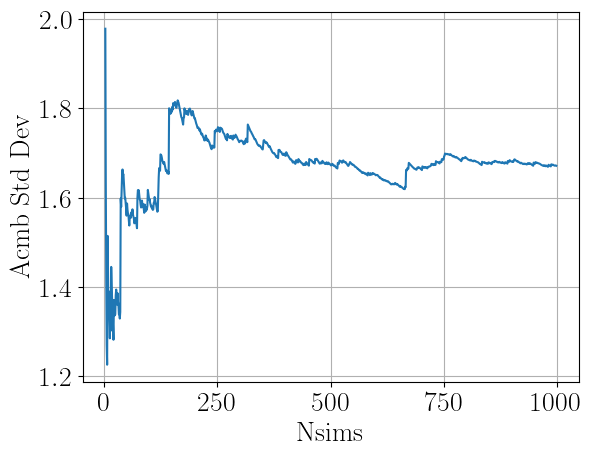

In [84]:
sims_arr = np.arange(2,1000)
cov_arr = [np.std(acmb_array_template_fitting[:sim]) for sim in sims_arr]
plt.plot(sims_arr, cov_arr)
plt.xlabel('Nsims')
plt.ylabel("Acmb Std Dev")
plt.grid()

Removed no burn in
Removed no burn in
saved pipeline_plots/acmb_atsz.pdf


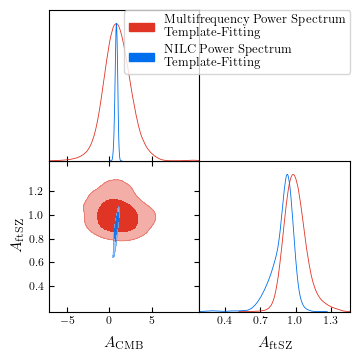

In [131]:
acmb_array_nilc = pickle.load(open(f'{inp.output_dir}/acmb_array_nilc.p', 'rb'))
atsz_array_nilc = pickle.load(open(f'{inp.output_dir}/atsz_array_nilc.p', 'rb'))
acmb_array_template_fitting = pickle.load(open(f'{inp.output_dir}/acmb_template_fitting_numerical.p', 'rb'))
atsz_array_template_fitting = pickle.load(open(f'{inp.output_dir}/atsz_template_fitting_numerical.p', 'rb'))

anoise1_array_nilc = pickle.load(open(f'{inp.output_dir}/anoise1_array_nilc.p', 'rb'))
anoise2_array_nilc = pickle.load(open(f'{inp.output_dir}/anoise2_array_nilc.p', 'rb'))
anoise1_array_template_fitting = pickle.load(open(f'{inp.output_dir}/anoise1_template_fitting_numerical.p', 'rb'))
anoise2_array_template_fitting = pickle.load(open(f'{inp.output_dir}/anoise2_template_fitting_numerical.p', 'rb'))

nilc_arrays = [acmb_array_nilc, atsz_array_nilc, anoise1_array_nilc, anoise2_array_nilc]
template_fitting_arrays = [acmb_array_template_fitting, atsz_array_template_fitting, anoise1_array_template_fitting, anoise2_array_template_fitting]

names = [r'$A_{\mathrm{CMB}}$', r'$A_{\mathrm{ftSZ}}$']
labels =  names

samples = MCSamples(samples=template_fitting_arrays[:2], names = names, labels = labels, label='Multifrequency Power Spectrum \nTemplate-Fitting')
samples2 = MCSamples(samples=nilc_arrays[:2], names = names, labels = labels, label='NILC Power Spectrum \nTemplate-Fitting')
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)

if save_dir:
    plt.savefig(f'{save_dir}/acmb_atsz.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/acmb_atsz.pdf')

Removed no burn in
Removed no burn in
saved pipeline_plots/all_scatter_plots.pdf


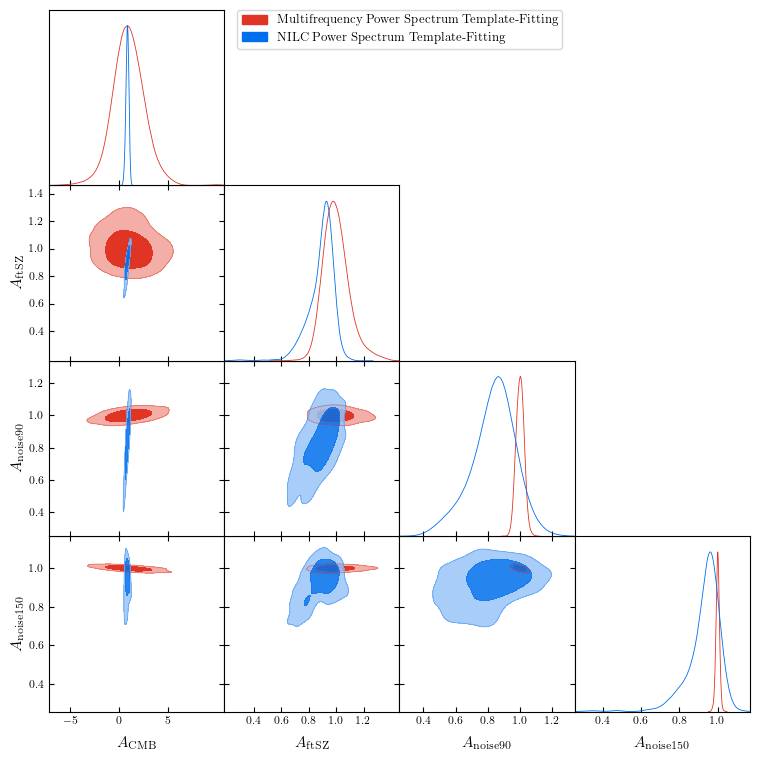

In [89]:
names = [r'$A_{\mathrm{CMB}}$', r'$A_{\mathrm{ftSZ}}$', r'$A_{\mathrm{noise90}}$', r'$A_{\mathrm{noise150}}$']
labels =  names
samples = MCSamples(samples=template_fitting_arrays, names = names, labels = labels, label='Multifrequency Power Spectrum Template-Fitting')
samples2 = MCSamples(samples=nilc_arrays,names = names, labels = labels, label='NILC Power Spectrum Template-Fitting')
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)

if save_dir:
    plt.savefig(f'{save_dir}/all_scatter_plots.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/all_scatter_plots.pdf')

# Corner plots from Multifrequency template-fitting MCMC

Removed no burn in
Removed no burn in
saved pipeline_plots/MLE_vs_MCMC.pdf


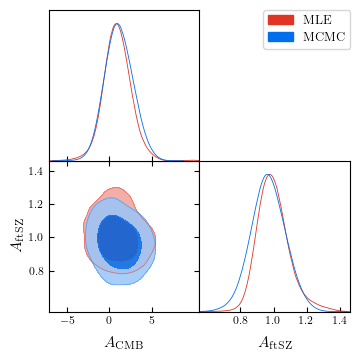

In [97]:
names = [r'$A_{\mathrm{CMB}}$', r'$A_{\mathrm{ftSZ}}$']
labels =  names

chains = pickle.load(open(f'{inp.output_dir}/MCMC_chains_multifrequency.p', 'rb'))
MCMC_template_fitting_arrays = np.zeros((2, 10000))
for i in range(10):
    for a in range(2):
        MCMC_template_fitting_arrays[a, i*1000: (i+1)*1000] = chains[:,i,a] 
        
samples = MCSamples(samples=[acmb_array_template_fitting, atsz_array_template_fitting], names = names, labels = labels, label='MLE')
samples2 = MCSamples(samples=list(MCMC_template_fitting_arrays),names = names, labels = labels, label='MCMC')
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)

if save_dir:
    plt.savefig(f'{save_dir}/MLE_vs_MCMC.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/MLE_vs_MCMC.pdf')


Removed no burn in
Removed no burn in


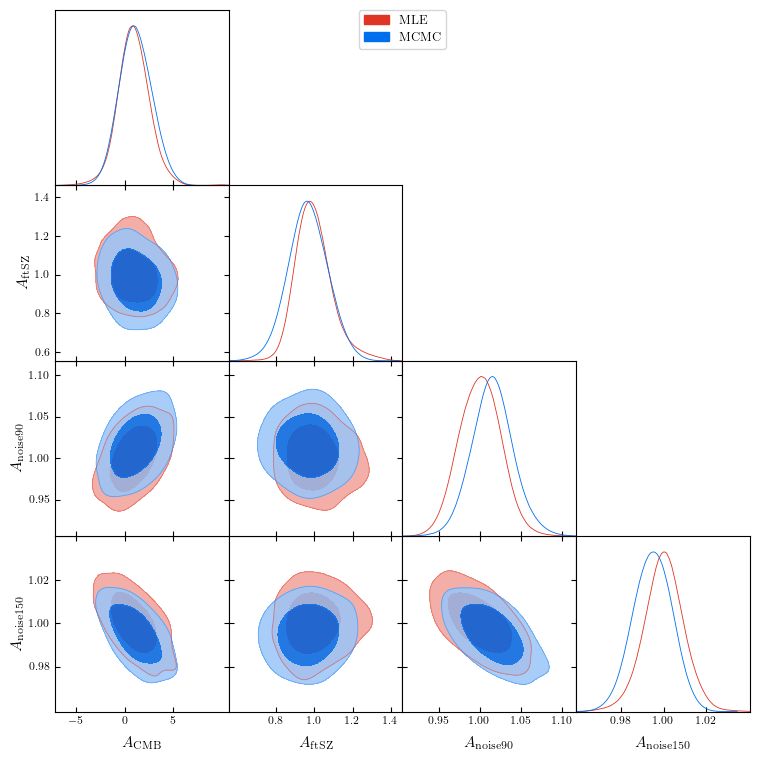

In [98]:
names = [r'$A_{\mathrm{CMB}}$', r'$A_{\mathrm{ftSZ}}$', r'$A_{\mathrm{noise90}}$', r'$A_{\mathrm{noise150}}$']
labels =  names

chains = pickle.load(open(f'{inp.output_dir}/MCMC_chains_multifrequency.p', 'rb'))
MCMC_template_fitting_arrays = np.zeros((4, 10000))
for i in range(10):
    for a in range(4):
        MCMC_template_fitting_arrays[a, i*1000: (i+1)*1000] = chains[:,i,a] 
        
samples = MCSamples(samples=template_fitting_arrays, names = names, labels = labels, label='MLE')
samples2 = MCSamples(samples=list(MCMC_template_fitting_arrays),names = names, labels = labels, label='MCMC')
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)




# Examine spread of ClTT, ClTy, and Clyy

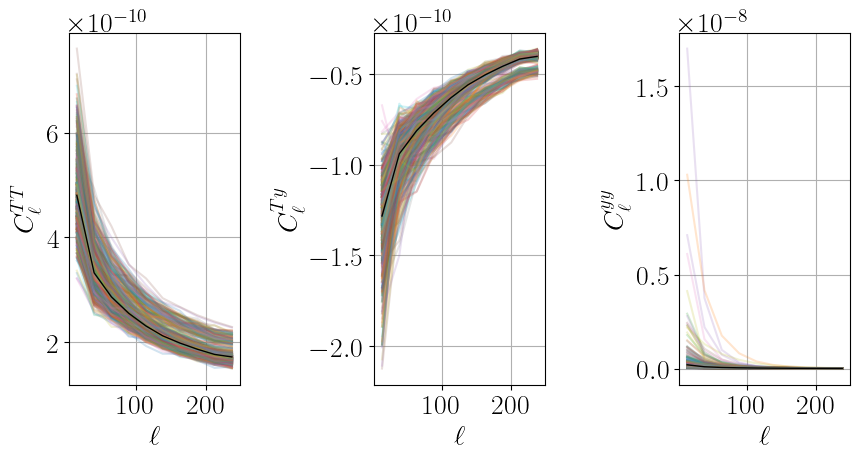

In [99]:
#Clpq has shape (Nsims, N_comps+1, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, ellmax+1)
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))
start = 0

fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
for p,q in [(0,0), (0,1), (1,1)]:
    plt.axes(axs[ax])
    for sim in range(len(Clpq)):
        plt.plot(mean_ells, np.sum(Clpq[sim,0,0,0,0,0,p,q,:,:], axis=(0,1))[start:], alpha=0.2)
    plt.plot(mean_ells, np.sum(np.mean(Clpq[:,0,0,0,0,0,p,q,:,:],axis=0), axis=(0,1))[start:], color='k', linewidth=1.)
    plt.grid()
    plt.xlabel(r'$\ell$')
    if ax==0: plt.ylabel(r'$C_\ell^{TT}$')
    if ax==1: plt.ylabel(r'$C_\ell^{Ty}$')
    if ax==2: plt.ylabel(r'$C_\ell^{yy}$')
    ax += 1
plt.tight_layout()

# Qualitative assessment of reconstruction using maximum likelihood parameters

## How well are ClTT, ClTy, and Clyy reconstructed with parameters for an individual realization?

best fit A parameters are:  0.62995845 0.7120281 0.6942245 0.73946047


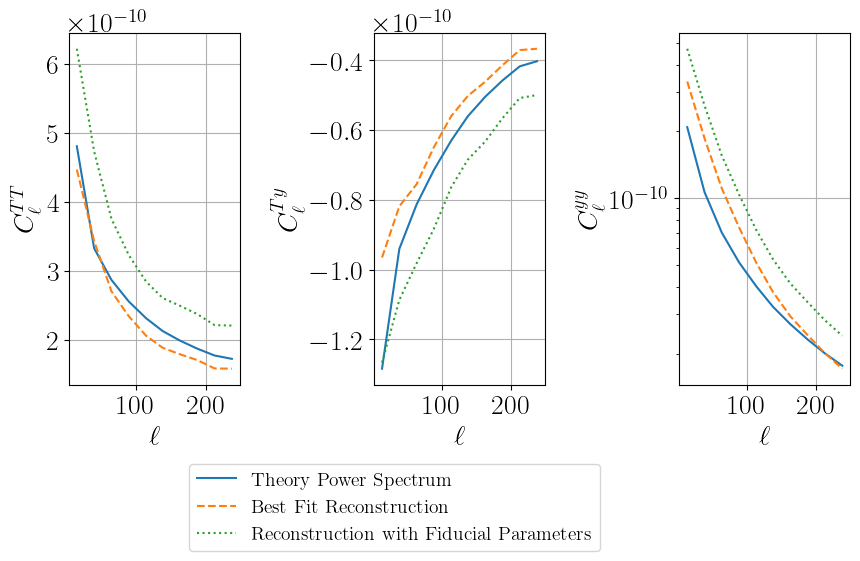

In [102]:
def call_fit(A_vec, expr):
    '''
    ARGUMENTS
    ---------
    A_vec: list of [Acmb, Atsz, Anoise1, Anoise2] independent variables
    expr: sympy expression of best fit involving parameters Acmb, Atsz, Anoise1, Anoise2,
        which map to x0, x1, x2, and x3, respectively 

    RETURNS
    -------
    numerical evaluation of expr at the point given by A_vec
    '''
    return expr.subs('x0', A_vec[0]).subs('x1', A_vec[1]).subs('x2', A_vec[2]).subs('x3', A_vec[3])



sim = 1
start = 0

#Clpq has shape (Nsims, N_comps+1, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, ellmax+1)
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))

#best_fits has shape (N_preserved_comps, N_preserved_comps, N_comps, N_comps, inp.ellmax+1, 4)
best_fits = pickle.load(open(f'{inp.output_dir}/data_vecs/best_fits.p', 'rb'))

ClTT_data = np.mean(np.sum(Clpq[:,0,0,0,0,0,0,0], axis=(1,2)), axis=0)
ClTy_data = np.mean(np.sum(Clpq[:,0,0,0,0,0,0,1], axis=(1,2)), axis=0)
Clyy_data = np.mean(np.sum(Clpq[:,0,0,0,0,0,1,1], axis=(1,2)), axis=0)

acmb = pickle.load(open(f'{inp.output_dir}/acmb_array_nilc.p', 'rb'))
atsz = pickle.load(open(f'{inp.output_dir}/atsz_array_nilc.p', 'rb'))
anoise1 = pickle.load(open(f'{inp.output_dir}/anoise1_array_nilc.p', 'rb'))
anoise2 = pickle.load(open(f'{inp.output_dir}/anoise2_array_nilc.p', 'rb'))
print("best fit A parameters are: ", acmb[sim], atsz[sim], anoise1[sim], anoise2[sim])

fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
for p,q in [(0,0), (0,1), (1,1)]:
    plt.axes(axs[ax])
    theory_model = np.zeros(inp.Nbins)
    fiducial_model = np.zeros(inp.Nbins)
    for y in range(4):
        for z in range(4):
            for ell in range(inp.Nbins):
                theory_model[ell] += call_fit([acmb[sim], atsz[sim], anoise1[sim], anoise2[sim]], best_fits[p][q][y][z][ell]) \
                                    * Clpq[sim,0,0,0,0,0,p,q,y,z,ell]
                fiducial_model[ell] += call_fit([1., 1., 1., 1.], best_fits[p][q][y][z][ell]) \
                                    * Clpq[sim,0,0,0,0,0,p,q,y,z,ell]
    if ax==0: 
        data_model = ClTT_data
        plt.ylabel(r'$C_\ell^{TT}$')
    elif ax==1: 
        data_model = ClTy_data
        plt.ylabel(r'$C_\ell^{Ty}$')
    else: 
        data_model = Clyy_data
        plt.ylabel(r'$C_\ell^{yy}$')
        plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.plot(mean_ells[start:], data_model[start:], label='Theory Power Spectrum')
    plt.plot(mean_ells[start:], theory_model[start:], label='Best Fit Reconstruction', linestyle='dashed')
    plt.plot(mean_ells[start:], fiducial_model[start:], label='Reconstruction with Fiducial Parameters', linestyle='dotted')
    plt.grid()
    ax += 1

handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(0.7, 0.05))
plt.tight_layout()
            

## How well are Cl90x90, Cl90x150, and Cl150x150 reconstructed with parameters for an individual realization?

best fit A parameters are:  [-1.2097766, 1.0343697, 0.95453256, 1.0172597]


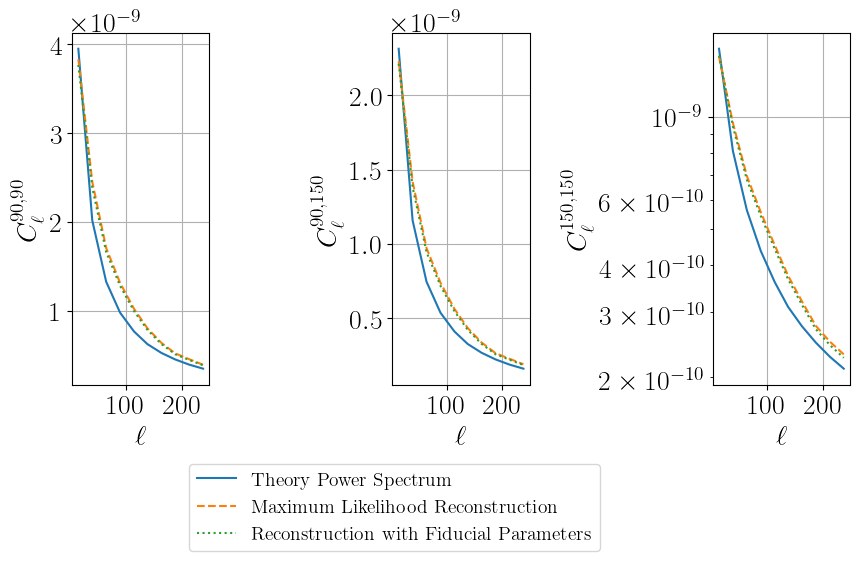

In [107]:
sim = 2

Clij = pickle.load(open(f'{inp.output_dir}/data_vecs/Clij.p', 'rb'))
Clij00_data = np.mean(Clij[:,0,0,0], axis=0)
Clij01_data = np.mean(Clij[:,0,1,0], axis=0)
Clij11_data = np.mean(Clij[:,1,1,0], axis=0)

acmb = pickle.load(open(f'{inp.output_dir}/acmb_template_fitting_numerical.p', 'rb'))
atsz = pickle.load(open(f'{inp.output_dir}/atsz_template_fitting_numerical.p', 'rb'))
anoise1 = pickle.load(open(f'{inp.output_dir}/anoise1_template_fitting_numerical.p', 'rb'))
anoise2 = pickle.load(open(f'{inp.output_dir}/anoise2_template_fitting_numerical.p', 'rb'))
res = [acmb[sim], atsz[sim], anoise1[sim], anoise2[sim]]
print("best fit A parameters are: ", res)

fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
for i,j in [(0,0), (0,1), (1,1)]:
    plt.axes(axs[ax])
    theory_model = np.einsum('ab,a->b', Clij[sim,i,j,1:], res)
    fiducial_model = np.einsum('ab,a->b', Clij[sim,i,j,1:], np.ones_like(res))
    alt_model = np.einsum('ab,a->b', Clij[sim,i,j,1:], [acmb_diag_cov[sim], atsz_diag_cov[sim], anoise1_diag_cov[sim], anoise2_diag_cov[sim]])
    if ax==0: 
        data_model = Clij00_data
        plt.ylabel(r'$C_\ell^{90,90}$')
    elif ax==1: 
        data_model = Clij01_data
        plt.ylabel(r'$C_\ell^{90,150}$')
    else: 
        data_model = Clij11_data
        plt.ylabel(r'$C_\ell^{150,150}$')
        plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.plot(mean_ells[start:], data_model[start:], label='Theory Power Spectrum')
    plt.plot(mean_ells[start:], theory_model[start:], label='Maximum Likelihood Reconstruction', linestyle='dashed')
    plt.plot(mean_ells[start:], fiducial_model[start:], label='Reconstruction with Fiducial Parameters', linestyle='dotted')
    plt.grid()
    ax += 1

handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(0.7, 0.05))
plt.tight_layout()
            

# Power Spectrum Covariance and Inverse Covariance Matrices

## View covariance coupling across scales for ClTT, ClTy, and Clyy in NILC approach

In [108]:
from matplotlib.colors import SymLogNorm, LogNorm
def get_PScov_sim(inp, Clpq_unscaled):
    '''
    ARGUMENTS
    ---------
    inp: Info object containing input paramter specifications
    Clpq_unscaled: (Nsims, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, Nbins) ndarray 
        containing propagation of each pair of component maps
        to NILC map auto- and cross-spectra
    
    RETURNS
    -------
    cov: (3*Nbins, 3*Nbins) ndarray containing covariance matrix Cov_{pq,rs}
        index as cov[(0-2 for ClTT ClTy Clyy)*Nbins + bin1, (0-2 for ClTT ClTy Clyy)*Nbins + bin2]
    '''
    Clpq_tmp = np.sum(Clpq_unscaled, axis=(3,4))
    Clpq_tmp = np.array([Clpq_tmp[:,0,0], Clpq_tmp[:,0,1], Clpq_tmp[:,1,1]])
    Clpq_tmp = np.transpose(Clpq_tmp, axes=(0,2,1)) #shape (3 for ClTT, ClTy, Clyy, Nbins, Nsims)
    Clpq_tmp = np.reshape(Clpq_tmp, (inp.Nbins*3, -1))
    cov = np.cov(Clpq_tmp)
    return cov

In [109]:
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))
N_comps = 4
Clpq_unscaled = Clpq[:,0,0,0,0,0]
PScov_sim_nilc = get_PScov_sim(inp, Clpq_unscaled)

PScov_sim_nilc_tensor = np.zeros((inp.Nbins, inp.Nbins, 3, 3))
for pq in range(3):
    for rs in range(3):
        for b1 in range(inp.Nbins):
            for b2 in range(inp.Nbins):
                PScov_sim_nilc_tensor[b1,b2,pq,rs] = PScov_sim_nilc[pq*inp.Nbins+b1, rs*inp.Nbins+b2]

saved pipeline_plots/NILC_corr_matrices.pdf


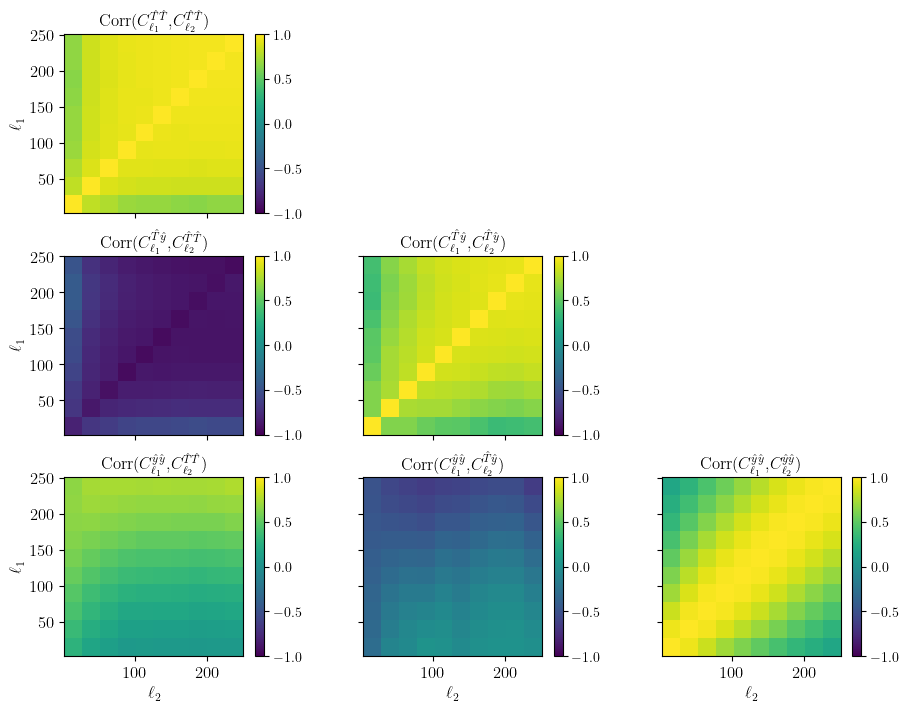

In [150]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{\ell_1}^{\hat{T}\hat{T}}$', r'$C_{\ell_1}^{\hat{T}\hat{y}}$', r'$C_{\ell_1}^{\hat{y}\hat{y}}$']
PS_strings2 = [r'$C_{\ell_2}^{\hat{T}\hat{T}}$', r'$C_{\ell_2}^{\hat{T}\hat{y}}$', r'$C_{\ell_2}^{\hat{y}\hat{y}}$']
diag = np.einsum('bbpp->bp', PScov_sim_nilc_tensor)
corr = np.einsum('bcpq,bp,cq->bcpq', PScov_sim_nilc_tensor, 1/np.sqrt(diag), 1/np.sqrt(diag))
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        if ax not in {1,2,5}:
            plt.imshow(corr[:,:,p,q], origin='lower', vmin=-1, vmax=1, extent=(2,inp.ellmax+1,2,inp.ellmax+1)) #use to plot correlation matrices
            #plt.imshow(PScov_sim_nilc_tensor[:,:,p,q], origin='lower', extent=(2,inp.ellmax+1,2,inp.ellmax+1)) #use to plot covariance matrices
            cbar = plt.colorbar()
            cbar.ax.tick_params(labelsize=10)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            if ax >= 6:
                plt.xlabel(r'$\ell_2$', fontsize=12)
            if ax % 3 == 0:
                plt.ylabel(r'$\ell_1$', fontsize=12)
            plt.title(f'Corr({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
        else:
            axs[ax].axis('off')
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/NILC_corr_matrices.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/NILC_corr_matrices.pdf')


In [151]:
PScov_sim_alt_Inv = scipy.linalg.inv(PScov_sim_nilc)
PScov_sim_Inv_nilc = np.zeros((inp.Nbins, inp.Nbins, 3, 3))
for b1 in range(inp.Nbins):
    for b2 in range(inp.Nbins):
        for i in range(3):
            for j in range(3):
                PScov_sim_Inv_nilc[b1, b2, i, j] = PScov_sim_alt_Inv[i*inp.Nbins+b1, j*inp.Nbins+b2]
PScov_sim_Inv_nilc *= (inp.Nsims-(inp.Nbins*3)-2)/(inp.Nsims-1) #correction factor from https://arxiv.org/pdf/astro-ph/0608064.pdf

Text(0.5, 0.98, 'Correlation Matrices for Inverse Covariance')

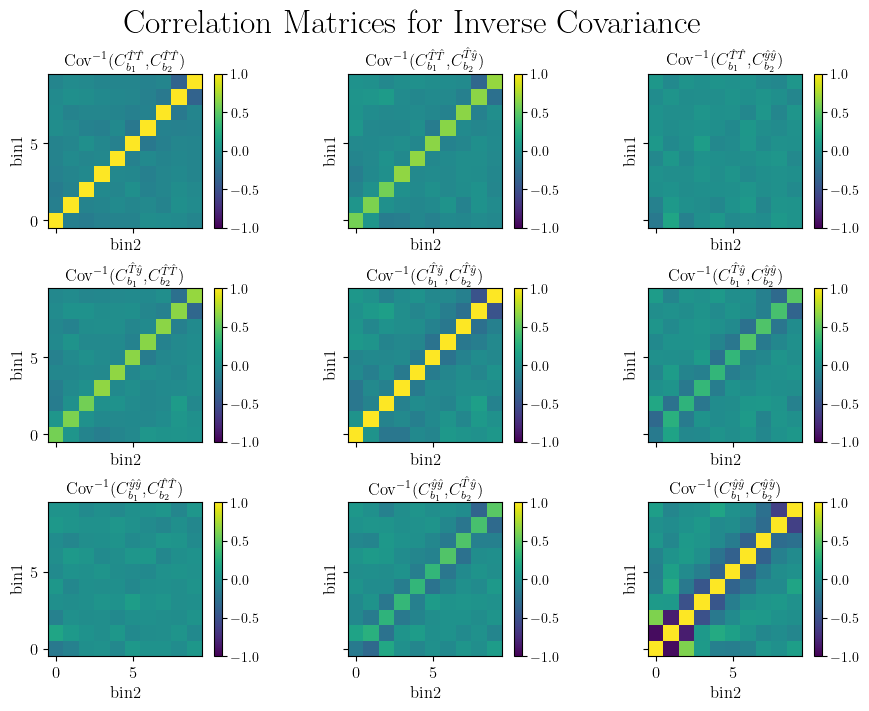

In [112]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{b_1}^{\hat{T}\hat{T}}$', r'$C_{b_1}^{\hat{T}\hat{y}}$', r'$C_{b_1}^{\hat{y}\hat{y}}$']
PS_strings2 = [r'$C_{b_2}^{\hat{T}\hat{T}}$', r'$C_{b_2}^{\hat{T}\hat{y}}$', r'$C_{b_2}^{\hat{y}\hat{y}}$']
diag = np.einsum('bbpp->bp', PScov_sim_Inv_nilc)
corr = np.einsum('bcpq,bp,cq->bcpq', PScov_sim_Inv_nilc, 1/np.sqrt(diag), 1/np.sqrt(diag))
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.imshow(corr[:,:,p,q], origin='lower', vmin=-1, vmax=1) #use to plot correlation matrices
#         plt.imshow(PScov_sim_Inv_nilc[:,:,p,q], origin='lower') #use to plot correlation matrices
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=10)
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel(r'bin2', fontsize=12)
        plt.ylabel(r'bin1', fontsize=12)
        plt.title(r'$\mathrm{Cov}^{-1}$' + f'({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
plt.suptitle('Correlation Matrices for Inverse Covariance')

Text(0, 0.5, 'Cov')

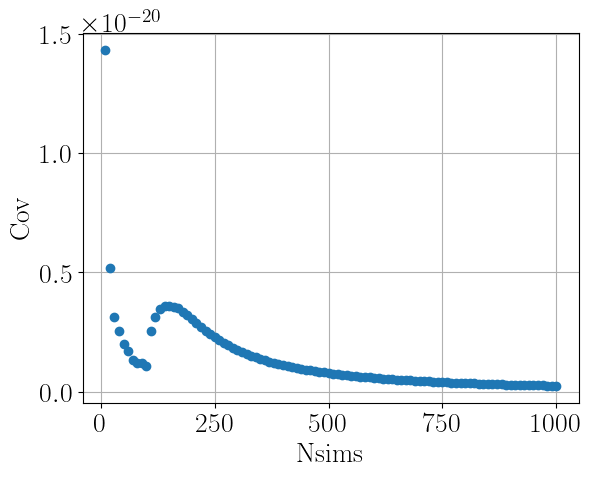

In [113]:
#Check convergence as Nsims increases

pq,rs = 0,0
b1,b2 = 4,7

covs = []
Nsims_arr = np.linspace(10, 1000, num=100)
for Nsims in Nsims_arr:
    PScov = get_PScov_sim(inp, Clpq_unscaled[:int(Nsims)])*(inp.Nsims-1)/(Nsims-1)
    covs.append(PScov[pq*inp.Nbins+b1,rs*inp.Nbins+b2])

plt.plot(Nsims_arr, covs, 'o')
plt.grid()
plt.xlabel("Nsims")
plt.ylabel("Cov")
    

## View covariance coupling across scales for Clij in template-fitting approach, measuring cov from sims

In [114]:
from acmb_atsz import get_PScov_sim
from matplotlib.colors import LogNorm
inp.use_Gaussian_cov = False

Nbins = 5
PScov_sim_template_fitting = get_PScov_sim(inp, Clij)

In [115]:
PScov_sim_template_fitting_tensor = np.zeros((inp.Nbins, inp.Nbins, 3, 3))
for ij in range(3):
    for kl in range(3):
        for b1 in range(inp.Nbins):
            for b2 in range(inp.Nbins):
                PScov_sim_template_fitting_tensor[b1,b2,ij,kl] = PScov_sim_template_fitting[ij*inp.Nbins+b1, kl*inp.Nbins+b2]

Text(0.5, 0.98, 'Correlation Matrices')

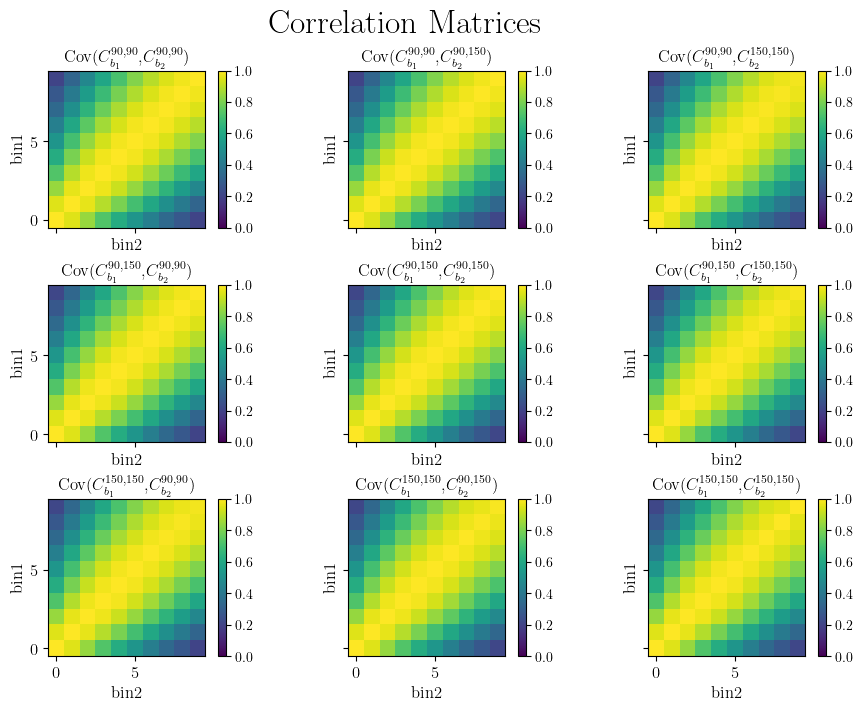

In [116]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
PS_strings2 = [r'$C_{b_2}^{90,90}$', r'$C_{b_2}^{90,150}$', r'$C_{b_2}^{150,150}$']
diag = np.einsum('bbpp->bp', PScov_sim_template_fitting_tensor)
corr = np.einsum('bcpq,bp,cq->bcpq', PScov_sim_template_fitting_tensor, 1/np.sqrt(diag), 1/np.sqrt(diag))
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.imshow(corr[:,:,p,q], origin='lower', vmin=0, vmax=1) #use for correlation matrices
        #plt.imshow(PScov_sim_template_fitting_tensor[:,:,p,q], origin='lower', norm=LogNorm()) #use for cov matrices
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=10)
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('bin2', fontsize=12)
        plt.ylabel('bin1', fontsize=12)
        plt.title(f'Cov({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
plt.suptitle('Correlation Matrices')
        

In [117]:
PScov_sim_alt_Inv = scipy.linalg.inv(PScov_sim_template_fitting)
PScov_sim_Inv_template_fitting = np.zeros((inp.Nbins, inp.Nbins, 3, 3))
for b1 in range(inp.Nbins):
    for b2 in range(inp.Nbins):
        for i in range(3):
            for j in range(3):
                PScov_sim_Inv_template_fitting[b1, b2, i, j] = PScov_sim_alt_Inv[i*inp.Nbins+b1, j*inp.Nbins+b2]
if not inp.use_Gaussian_cov:
    PScov_sim_Inv_template_fitting *= (inp.Nsims-(inp.Nbins*3)-2)/(inp.Nsims-1) #correction factor from https://arxiv.org/pdf/astro-ph/0608064.pdf

Text(0.5, 0.98, 'Correlation Matrices for Inverse Covariance')

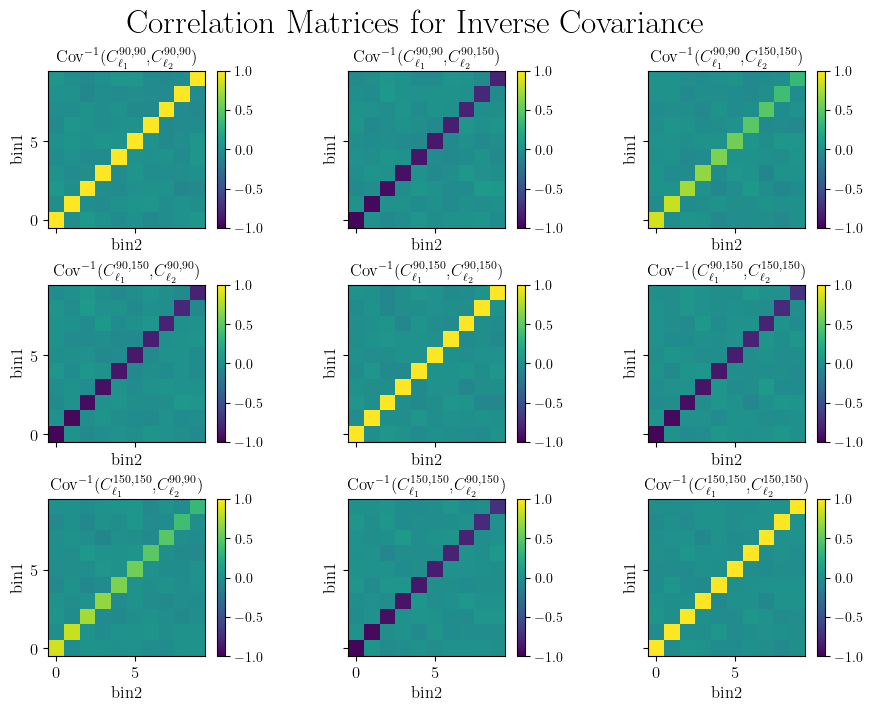

In [118]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{\ell_1}^{90,90}$', r'$C_{\ell_1}^{90,150}$', r'$C_{\ell_1}^{150,150}$']
PS_strings2 = [r'$C_{\ell_2}^{90,90}$', r'$C_{\ell_2}^{90,150}$', r'$C_{\ell_2}^{150,150}$']
diag = np.einsum('bbpp->bp', PScov_sim_Inv_template_fitting)
corr = np.einsum('bcpq,bp,cq->bcpq', PScov_sim_Inv_template_fitting, 1/np.sqrt(diag), 1/np.sqrt(diag))
# corr = PScov_sim_Inv_template_fitting
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.imshow(corr[:,:,p,q],origin='lower', vmin=-1, vmax=1)
#         plt.imshow(PScov_sim_Inv_template_fitting[:,:,p,q], origin='lower', vmin=np.amin(PScov_sim_Inv_template_fitting), vmax=np.amax(PScov_sim_Inv_template_fitting)) #use for cov matrices
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=10)
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('bin2', fontsize=12)
        plt.ylabel('bin1', fontsize=12)
        plt.title(r'$\mathrm{Cov}^{-1}$' + f'({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
plt.suptitle('Correlation Matrices for Inverse Covariance')

Text(0, 0.5, 'Cov')

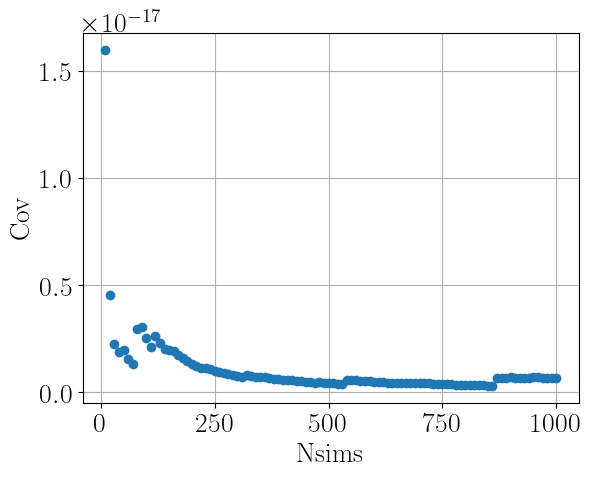

In [119]:
ij,kl = 0,1
b1,b2 = 2,3
# ij,kl = 1,1
# b1,b2 = 7,9

covs = []
Nsims_arr = np.linspace(10, 1000, num=100)
for Nsims in Nsims_arr:
    PScov = get_PScov_sim(inp, Clij[:int(Nsims)])*(inp.Nsims-1)/(Nsims-1)
    covs.append(PScov[ij*inp.Nbins+b1,kl*inp.Nbins+b2])

plt.plot(Nsims_arr, covs, 'o')
plt.grid()
plt.xlabel("Nsims")
plt.ylabel("Cov")
    

## Template-fitting Gaussian power spectrum covariance calculation

In [120]:
PScov_gaussian = np.zeros((inp.Nbins, inp.Nbins, 3, 3))

Clij_tmp = np.mean(Clij, axis=0) #dim (Nfreqs=2, Nfreqs=2, 1+Ncomps, Nbins)
g1, g2 = tsz_spectral_response(inp.freqs) #tSZ spectral response at 90 and 150 GHz
CC = Clij_tmp[0,0,1] #CMB
T = Clij_tmp[0,0,2]/g1**2 #tSZ (in Compton-y)
N1 = Clij_tmp[0,0,3] #noise 90 GHz
N2 = Clij_tmp[1,1,4] #noise 150 GHz
Clij_tmp = Clij_tmp[:,:,0]
f = 1. #fraction of sky

#get mean ell in each bin
res = stats.binned_statistic(np.arange(inp.ellmax+1)[2:], np.arange(inp.ellmax+1)[2:], statistic='mean', bins=inp.Nbins)
mean_ells = (res[1][:-1]+res[1][1:])/2

for bin in np.arange(inp.Nbins):
    Nmodes = f*(2*mean_ells[bin]+1)*(res[1][bin+1]-res[1][bin])
    PScov_gaussian[bin, bin] = (1/Nmodes)*np.array([
                [2*Clij_tmp[0, 0, bin]**2,
                    2*(CC[bin] + g1**2*T[bin])*Clij_tmp[0, 1, bin] + 2*N1[bin]*Clij_tmp[0, 1, bin],
                    2*Clij_tmp[0, 1, bin]**2], 
                [2*(CC[bin] + g1**2*T[bin])*Clij_tmp[0, 1, bin] + 2*N1[bin]*Clij_tmp[0, 1, bin], 
                    Clij_tmp[0, 0, bin]*Clij_tmp[1, 1, bin] + Clij_tmp[0, 1, bin]**2,
                    2*(CC[bin] + g2**2*T[bin])*Clij_tmp[0, 1, bin] + 2*N2[bin]*Clij_tmp[0, 1, bin]], 
                [2*Clij_tmp[0, 1, bin]**2, 
                    2*(CC[bin] + g2**2*T[bin])*Clij_tmp[0, 1, bin] + 2*N2[bin]*Clij_tmp[0, 1, bin],
                    2*Clij_tmp[1, 1, bin]**2]])

Text(0.5, 0.98, 'Correlation Matrices for Gaussian Covariance')

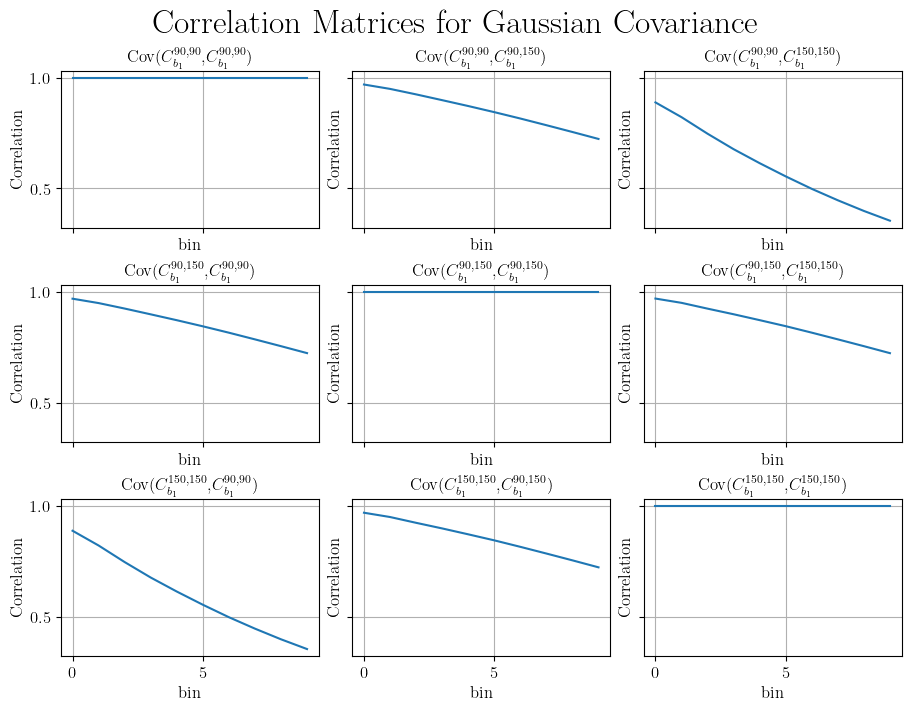

In [121]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 5
PS_strings1 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
PS_strings2 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
diag = np.einsum('bbpp->bp', PScov_gaussian)
corr = np.einsum('bcpq,bp,cq->bcpq', PScov_gaussian, 1/np.sqrt(diag), 1/np.sqrt(diag))
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.plot(np.diagonal(corr[:,:,p,q]))
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('bin', fontsize=12)
        plt.ylabel('Correlation', fontsize=12)
        plt.title(f'Cov({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
        plt.grid()
plt.suptitle('Correlation Matrices for Gaussian Covariance')

## Ratio of template-fitting covariance matrices using Gaussian cov matrix and cov measured from sims

Text(0.5, 0.98, 'Gaussian/Simulated PS Cov Matrices')

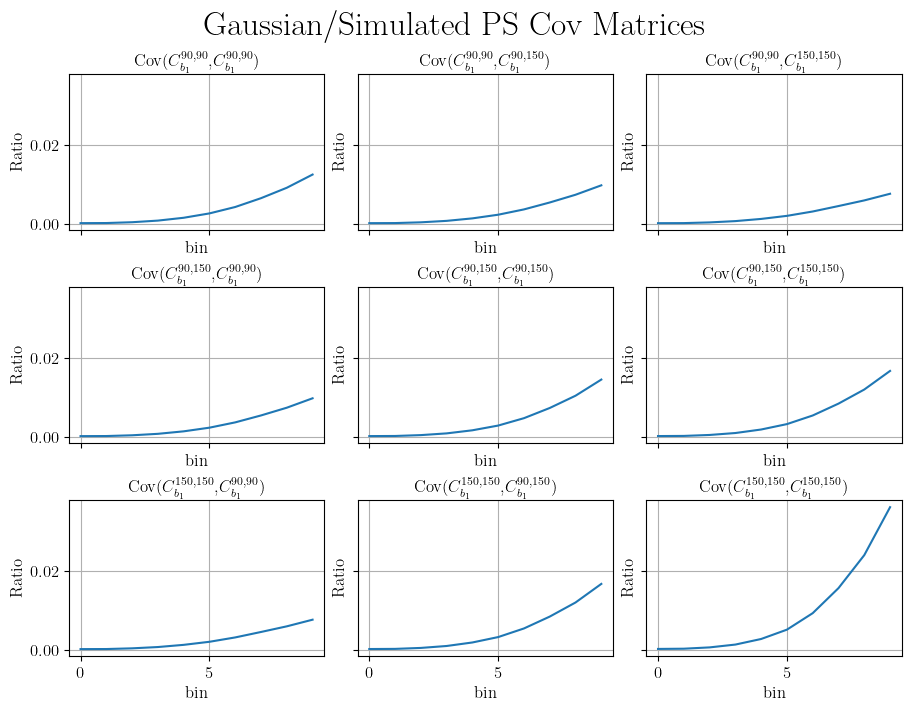

In [122]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
PS_strings2 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.plot(np.diagonal(PScov_gaussian[:,:,p,q])/np.diagonal(PScov_sim_template_fitting_tensor[:,:,p,q]))
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('bin', fontsize=12)
        plt.ylabel('Ratio', fontsize=12)
        plt.title(f'Cov({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
        plt.grid()
plt.suptitle('Gaussian/Simulated PS Cov Matrices')
        

## Ratio of template-fitting inverse covariance matrices using Gaussian cov matrix and cov measured from sims

In [123]:
PScov_alt_gaussian = np.zeros((3*inp.Nbins, 3*inp.Nbins))
for b1 in range(inp.Nbins):
    for b2 in range(inp.Nbins):
        for ij in range(3):
            for kl in range(3):
                PScov_alt_gaussian[ij*inp.Nbins+b1, kl*inp.Nbins+b2] = PScov_gaussian[b1,b2,ij,kl]
PScov_alt_Inv_gaussian = scipy.linalg.inv(PScov_alt_gaussian)
PScov_Inv_gaussian = np.zeros((inp.Nbins, inp.Nbins, 3, 3))
for b1 in range(inp.Nbins):
    for b2 in range(inp.Nbins):
        for i in range(3):
            for j in range(3):
                PScov_Inv_gaussian[b1, b2, i, j] = PScov_alt_Inv_gaussian[i*inp.Nbins+b1, j*inp.Nbins+b2]

Text(0.5, 0.98, 'Gaussian/Simulated Inverse PS Cov Matrix Ratios')

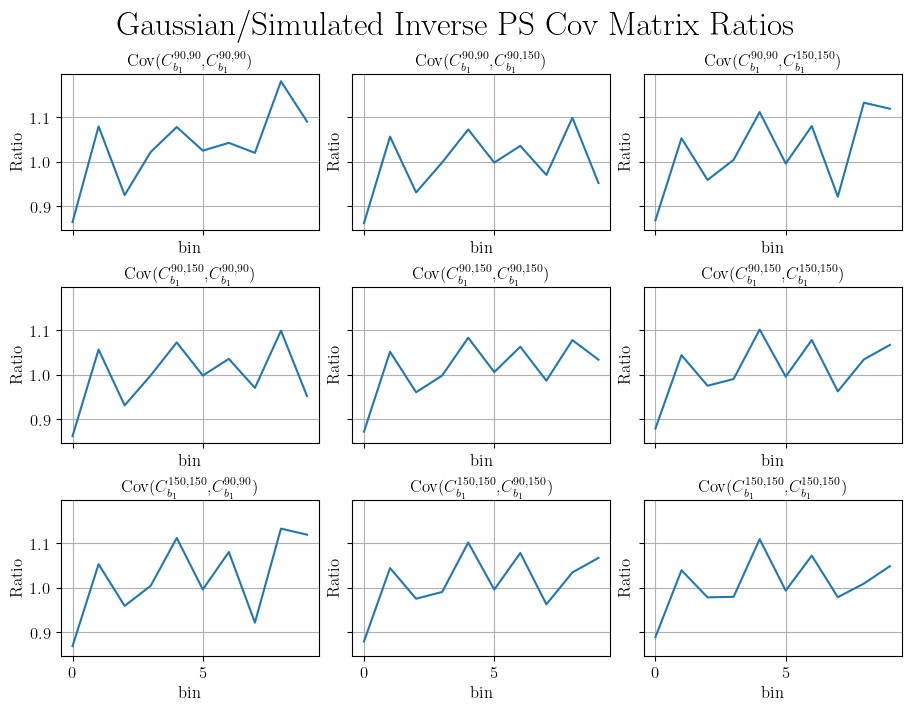

In [124]:
fig, axs = plt.subplots(3,3, figsize=(9,7), sharex=True, sharey=True, layout='constrained')
axs = axs.flatten()
ax = 0
start = 0
PS_strings1 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
PS_strings2 = [r'$C_{b_1}^{90,90}$', r'$C_{b_1}^{90,150}$', r'$C_{b_1}^{150,150}$']
for p in range(3):
    for q in range(3):
        plt.axes(axs[ax])
        plt.plot(np.diagonal(PScov_Inv_gaussian[:,:,p,q])/np.diagonal(PScov_sim_Inv_template_fitting[:,:,p,q]))
        ax += 1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('bin', fontsize=12)
        plt.ylabel('Ratio', fontsize=12)
        plt.title(f'Cov({PS_strings1[p]},{PS_strings2[q]})', fontsize=12)
        plt.grid()
plt.suptitle('Gaussian/Simulated Inverse PS Cov Matrix Ratios')
        

# Examine parameter dependence for NILC from symbolic regression

saved pipeline_plots/scaling_ClTT.pdf
saved pipeline_plots/scaling_ClTy.pdf
saved pipeline_plots/scaling_Clyy.pdf


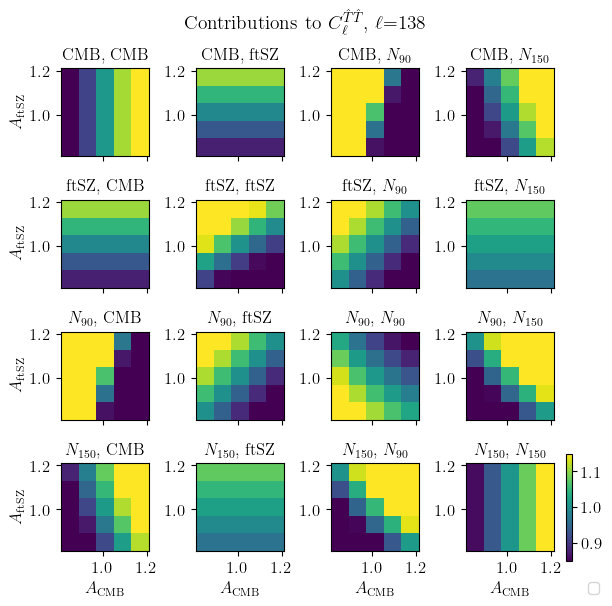

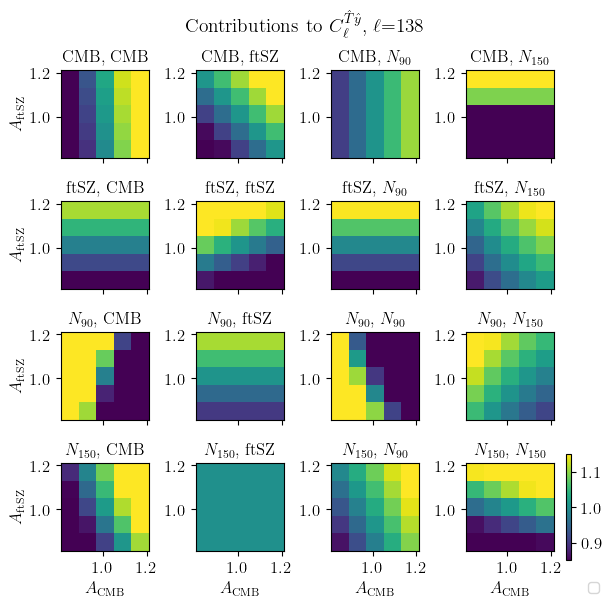

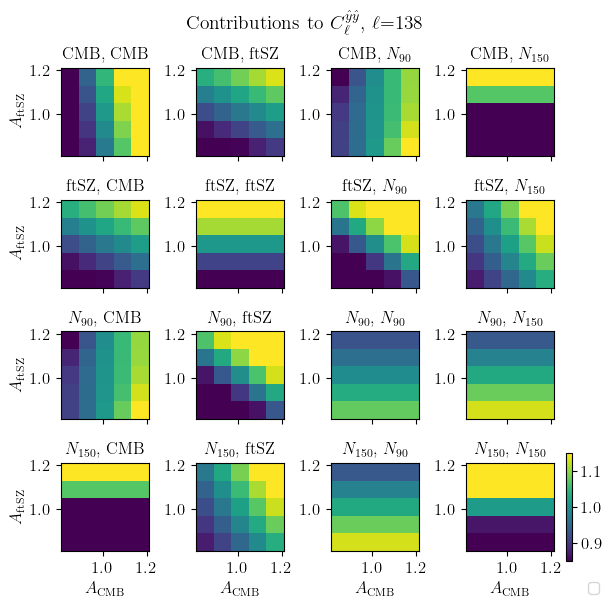

In [137]:
b = 5 #bin
npoints = 5
start_val, end_val = np.array(inp.scaling_factors)**2
acmb_test_vals = np.linspace(start_val, end_val, npoints)
atsz_test_vals = np.linspace(start_val, end_val, npoints)
comps = ['CMB', 'ftSZ', r'$N_{90}$', r'$N_{150}$']

for p,q in [(0,0), (0,1), (1,1)]:
    fig, axs = plt.subplots(4,4, figsize=(6,6), sharey=False, sharex=True, layout='constrained')
    axs = axs.flatten()
    ax = 0
    for y in range(4):
        for z in range(4):
            plt.axes(axs[ax])
            arr = np.zeros((npoints, npoints))

            for i,acmb in enumerate(acmb_test_vals):
                for j,atsz in enumerate(atsz_test_vals):
                    arr[j,i] = call_fit([acmb, atsz, 1., 1.], best_fits[p][q][y][z][b])

            plt.imshow(arr, extent=[start_val, end_val, start_val, end_val,], vmin=0.85, vmax=1.15, origin='lower')
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            
            if ax >= 12:
                plt.xlabel(r'$A_{\mathrm{CMB}}$', fontsize=12)
            if ax%4==0:
                plt.ylabel(r'$A_{\mathrm{ftSZ}}$', fontsize=12)
            plt.title(f'{comps[y]}, {comps[z]}', fontsize=12)
            ax += 1
            
    handles, labels = axs[-1].get_legend_handles_labels() 
    fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.0, 0.05), ncol=2)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)
    if (p,q)==(0,0): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{T}}$, ' + r'$\ell$' + f'={int(np.round(mean_ells[b]))}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/scaling_ClTT.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/scaling_ClTT.pdf')
    elif (p,q)==(0,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{y}}$, ' + r'$\ell$' + f'={int(np.round(mean_ells[b]))}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/scaling_ClTy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/scaling_ClTy.pdf')
    elif (p,q)==(1,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{y}\hat{y}}$, ' + r'$\ell$' + f'={int(np.round(mean_ells[b]))}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/scaling_Clyy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/scaling_Clyy.pdf')



In [135]:
best_fits[0][0][2][2]

[1.2663776*x0 - 0.26325747*x1,
 1.01722080566878*x0 - 0.22253944*x1 + 0.22253944*x2,
 0.393202087719704*x0 - 0.35998642*x1 + x2,
 x2 + 0.46005914*(-x1 + 1.07245775551365*x2)/x0,
 -0.432991211101098*x1 + x2 + 0.027520437 + 0.432991211101098*x2**2/x0,
 -0.494143290188859*x1 + x2 + 0.019417474240928 + 0.494143290188859*x2**2/x0,
 0.5479784*x0 - 0.5479784*x1 + x2**2/x0,
 (x0*x2 + x2**3/x0)/(x0 + x1),
 x2**2/(0.469166032979745*x0 + 0.530833967020255*x1),
 (0.23638202*x0 - 0.23638202*x1 + x2)**2/(x0 - 0.016891899)]

# HILC vs. Template-fitting with data-split cross-spectra

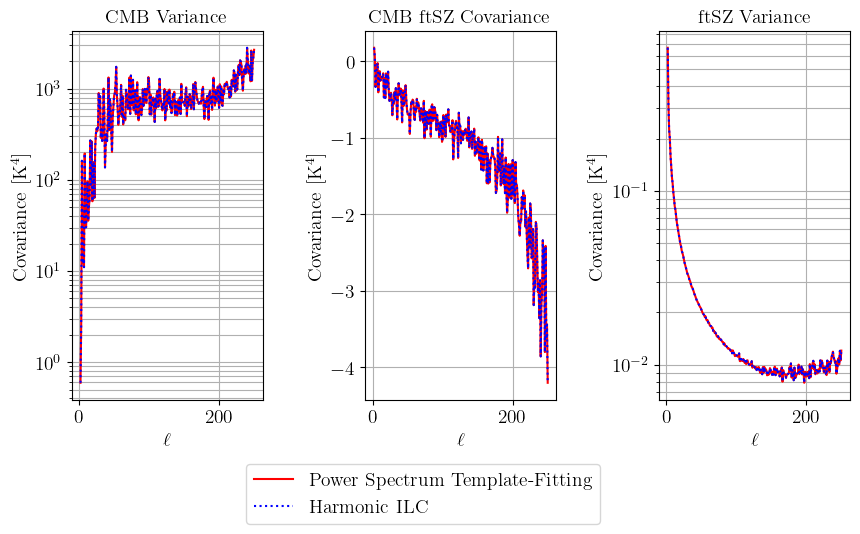

In [126]:
FinalCovILC = pickle.load(open(f'{inp.output_dir}/data_splits_hilc_cov.p', 'rb'))
FinalCovTemplateFitting = pickle.load(open(f'{inp.output_dir}/data_splits_template_fitting_cov.p', 'rb'))
fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
ells_unbinned = np.arange(2, inp.ellmax+1)
for i in range(3):
    plt.axes(axs[ax])
    if i==0: 
        ILC_var, template_fitting_var = FinalCovILC[0,0], FinalCovTemplateFitting[0,0]
        plt.title('CMB Variance', fontsize=14)
    elif i==1: 
        ILC_var, template_fitting_var = FinalCovILC[0,1], FinalCovTemplateFitting[0,1]
        plt.title('CMB ftSZ Covariance', fontsize=14)
    elif i==2: 
        ILC_var, template_fitting_var = FinalCovILC[1,1], FinalCovTemplateFitting[1,1]
        plt.title('ftSZ Variance', fontsize=14)
    plt.plot(ells_unbinned, template_fitting_var, label='Power Spectrum Template-Fitting', color='red')
    plt.plot(ells_unbinned, ILC_var, label='Harmonic ILC', linestyle='dotted', color='blue')
    if i==0 or i==2: plt.yscale('log')
    plt.xlabel(r'$\ell$', fontsize=14)
    plt.ylabel(r'Covariance $[\mathrm{K}^4]$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(which='both')
    ax += 1
handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(0.7, 0.05))
plt.tight_layout()
plt.savefig(f'{save_dir}/data_splits_hilc_vs_template_fitting.pdf', bbox_inches = "tight")